# Using Ibis and Altair for OmniSci

In this notebook, we will use Ibis to build OmniSci query and then use Altair to compose a visualization on top of it.

We will be plotting a map of a bunch of tweets.

## Assembling the Query
First, let's connect to the omnisci backend and assemble the query:

In [1]:
import jupyterlab_omnisci
import ibis
import altair as alt

In [2]:
omnisci_cli = ibis.heavyai.connect(
    host='localhost', user='admin', password='HyperInteractive',
    database='heavyai', protocol= 'https'
)

In [3]:
t = omnisci_cli.table('tweets_nov_feb')

In [4]:
expr = t[t.goog_x.name('x'), t.goog_y.name('y'), t.tweet_id.name('rowid')]
print(expr.compile())

SELECT "goog_x" AS x, "goog_y" AS y, "tweet_id" AS rowid
FROM tweets_nov_feb


## Browser rendering
Now, let's first try rendering this by getting a Pandas DataFrame 
and rendering this on the browser

In [5]:
df = expr.execute()
df.head()

,x,y,rowid
0,-8262344.5,5.108968e+05,528343124733878272
1,-9225572.0,4.862433e+06,528343040591556608
2,-7174107.5,-3.662602e+06,528343040684208128
3,-5185821.0,-2.693298e+06,528343124779999232
4,-10608033.0,3.505821e+06,528343124691546112


This is a lot of data, so let's tell Altair to save it as a temporary JSON file. 

This way it all won't be stored in the notebook

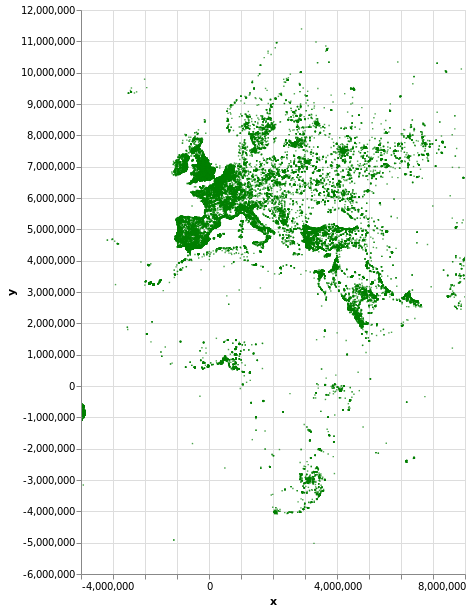

In [6]:
alt.data_transformers.enable('json')
alt.renderers.enable('default')
alt.Chart(df, width=384, height=564).mark_square(
    color='green',
    size=2,
    clip=True
).encode(
    alt.X(
        'x:Q',
        scale=alt.Scale(domain=[-3650484.1235206556, 7413325.514451755], range='width')
    ),
    alt.Y(
        'y:Q',
        scale=alt.Scale(domain=[-5778161.9183506705, 10471808.487466192], range='height')
    ),
)

## OmniSci Rendering

That looks OK, but we seem to be missing some data! Well omnisci's API has a default max row limit. Instead of increasing this, let's move all the computation to omnisci, so that
we don't have to send all the data to the client, just the rendered graphic.

We enable the omnisci renderer with our connection info and then Altair will treat the string we pass in as a Mapd SQL query.

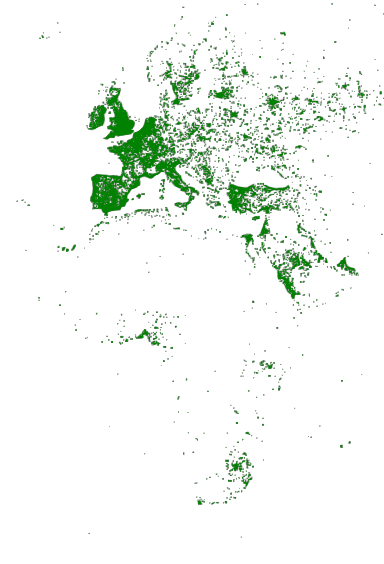

In [7]:
# alt.datat
alt.renderers.enable('ibis', extract=False, compile=False, type='vl-omnisci')
alt.data_transformers.enable('ibis')

alt.Chart(expr, width=384, height=564).mark_square(
    color='green',
    size=2,
    clip=True
).encode(
    alt.X(
        'x:Q',
        scale=alt.Scale(domain=[-3650484.1235206556, 7413325.514451755], range='width')
    ),
    alt.Y(
        'y:Q',
        scale=alt.Scale(domain=[-5778161.9183506705, 10471808.487466192], range='height')
    ),
)

You see that we used the exact same Altair code, but we just changed the input. However, it does look a bit different because OmniScis vega backend doesn't behave the same as the standard javascript one. 